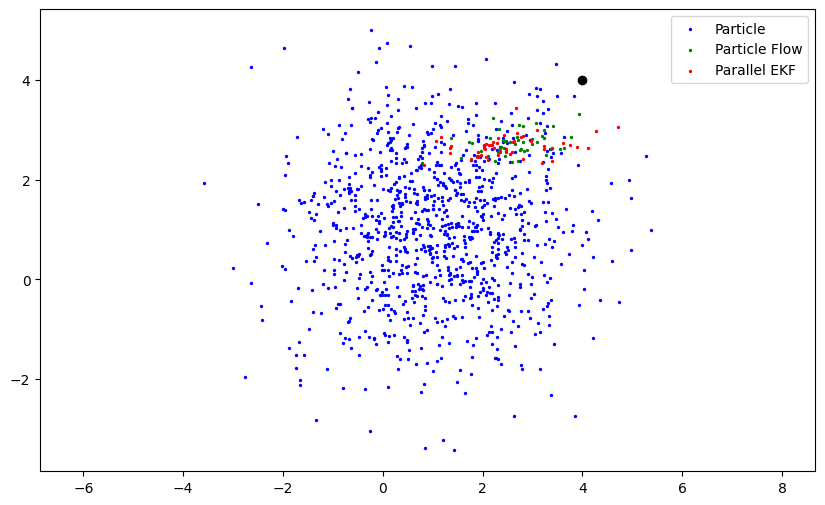

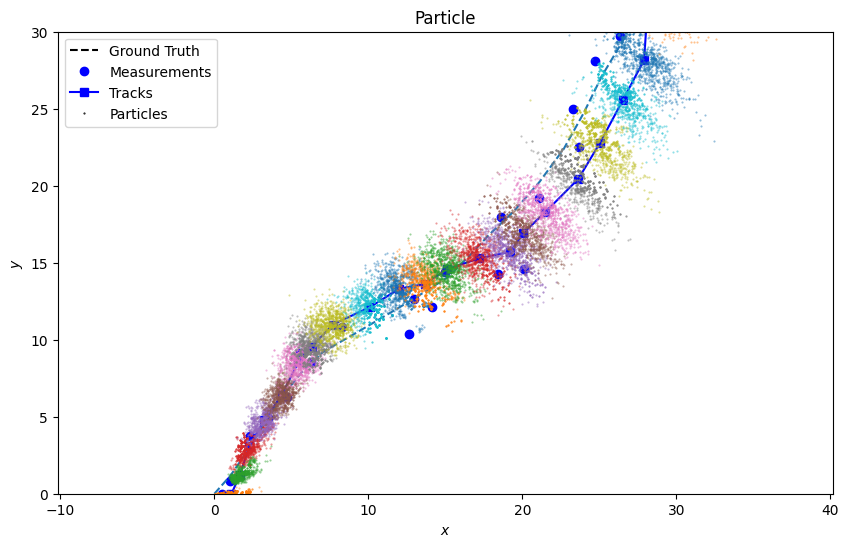

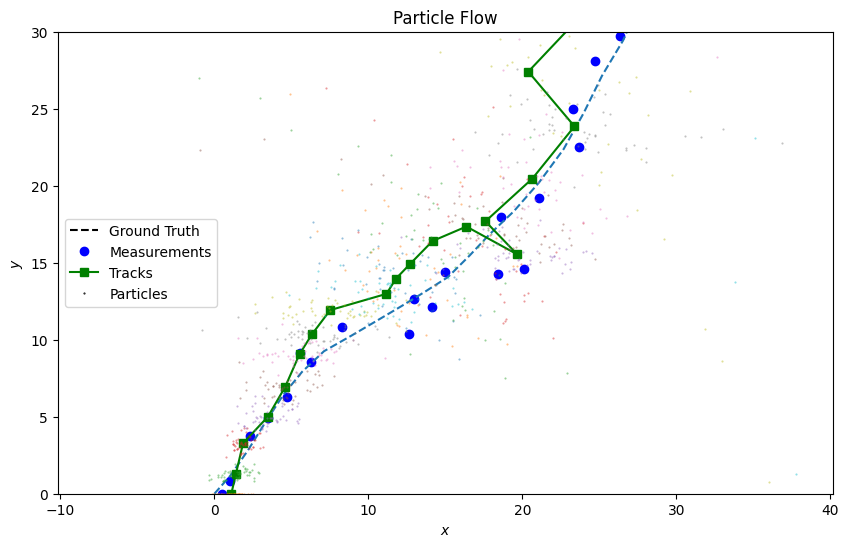

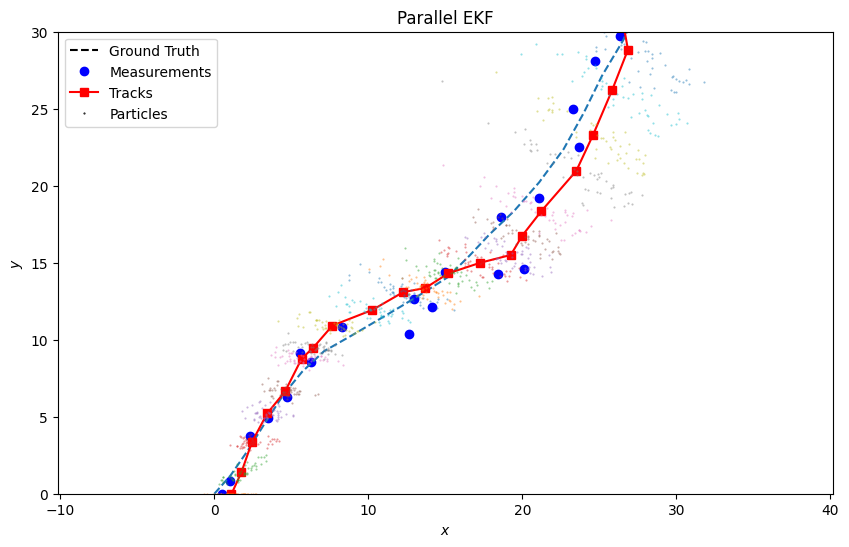

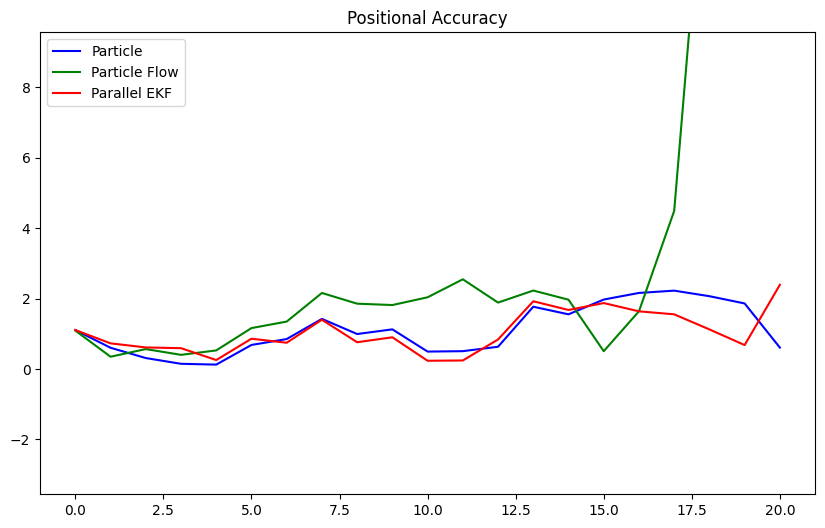

In [2]:
import datetime
import numpy as np
from scipy.stats import multivariate_normal

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange
from stonesoup.types.detection import Detection
from stonesoup.predictor.particle import ParticlePredictor, ParticleFlowKalmanPredictor
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
    ConstantVelocity
from stonesoup.updater.particle import ParticleUpdater, GromovFlowParticleUpdater, \
    GromovFlowKalmanParticleUpdater
from stonesoup.types.particle import Particle
from stonesoup.types.numeric import Probability
from stonesoup.types.state import ParticleState

np.random.seed(2020)

start_time = datetime.datetime(2020, 1, 1)
truth = GroundTruthPath([
    GroundTruthState([4, 4, 4, 4], timestamp=start_time + datetime.timedelta(seconds=1))
])

measurement_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.diag([np.radians(0.5), 1])
)
measurement = Detection(measurement_model.function(truth.state, noise=True),
                        timestamp=truth.state.timestamp,
                        measurement_model=measurement_model)

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.05),
                                                          ConstantVelocity(0.05)])

p_predictor = ParticlePredictor(transition_model)
pfk_predictor = ParticleFlowKalmanPredictor(transition_model)  # By default, parallels EKF
predictors = [p_predictor, p_predictor, pfk_predictor]

p_updater = ParticleUpdater(measurement_model)
f_updater = GromovFlowParticleUpdater(measurement_model)
pfk_updater = GromovFlowKalmanParticleUpdater(measurement_model)  # By default, parallels EKF
updaters = [p_updater, f_updater, pfk_updater]

number_particles = 1000
samples = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1.5, 0.5, 1.5, 0.5]),
                                  size=number_particles)
# Note weights not used in particle flow, so value won't effect it.
weight = Probability(1/number_particles)
particles = [
    Particle(sample.reshape(-1, 1), weight=weight) for sample in samples]

from matplotlib import pyplot as plt
from stonesoup.types.hypothesis import SingleHypothesis

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis('equal')

filters = ['Particle', 'Particle Flow', 'Parallel EKF']
particle_counts = [1000, 50, 50]
colours = ['blue', 'green', 'red']
handles, labels = [], []

for predictor, updater, colour, filter, particle_count \
        in zip(predictors, updaters, colours, filters, particle_counts):
    prior = ParticleState(None, particle_list=particles[:particle_count], timestamp=start_time)

    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)
    post = updater.update(hypothesis)

    handles.append(ax.scatter(post.state_vector[0, :], post.state_vector[2, :], color=colour, s=2))

    labels.append(filter)

ax.scatter(*truth.state_vector[[0, 2]], color='black')
ax.legend(handles=handles, labels=labels)

truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(
        GroundTruthState(transition_model.function(truth[k-1],
                                                   noise=True,
                                                   time_interval=datetime.timedelta(seconds=1)),
                         timestamp=start_time+datetime.timedelta(seconds=k))
    )

measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement, timestamp=state.timestamp,
                                  measurement_model=measurement_model))


number_particles = 1000
samples = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1.5, 0.5, 1.5, 0.5]),
                                  size=number_particles)
weight = Probability(1/number_particles)
particles = [Particle(sample.reshape(-1, 1), weight=weight)
             for sample in samples]

from stonesoup.resampler.particle import SystematicResampler
from stonesoup.types.track import Track
from stonesoup.dataassociator.tracktotrack import TrackToTruth
from stonesoup.metricgenerator.manager import SimpleManager
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.plotter import Plotter
from stonesoup.measures import Euclidean

updaters[0].resampler = SystematicResampler()  # Allow particle filter to re-sample

pa = dict()
siap_gen = SIAPMetrics(position_measure=Euclidean((0, 2)), velocity_measure=Euclidean((1, 3)))

for predictor, updater, colour, filter, particle_count \
        in zip(predictors, updaters, colours, filters, particle_counts):
    track = Track()
    prior = ParticleState(None, particle_list=particles[:particle_count], timestamp=start_time)

    for measurement in measurements:
        prediction = predictor.predict(prior, timestamp=measurement.timestamp)
        hypothesis = SingleHypothesis(prediction, measurement)
        post = updater.update(hypothesis)
        track.append(post)
        prior = track[-1]

    plotter = Plotter()
    plotter.plot_ground_truths(truth, [0, 2])
    plotter.plot_measurements(measurements, [0, 2])
    plotter.plot_tracks(track, [0, 2], particle=True, color=colour)
    plotter.ax.set_title(filter)
    plotter.ax.set_xlim(0, 30)
    plotter.ax.set_ylim(0, 30)

    metric_manager = SimpleManager(
        [siap_gen], associator=TrackToTruth(association_threshold=np.inf))
    metric_manager.add_data(tracks={track}, groundtruth_paths={truth})

    metrics = metric_manager.generate_metrics()
    pa[filter] = metrics.get("SIAP Position Accuracy at times")
    

from matplotlib.lines import Line2D

fig2 = plt.figure(figsize=(10, 6))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.axis('equal')

handles = list()
labels = list()

for (filter, value), colour in zip(pa.items(), colours):
    ax2.plot(range(len(value.value)), [elem.value for elem in value.value], color=colour)
    handles.append(Line2D([], [], color=colour))
    labels.append(filter)
ax2.legend(handles=handles, labels=labels)
ax2.set_ylim(0, 6)
_ = ax2.set_title('Positional Accuracy')